In [53]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [54]:
import pandas as pd
combined_df = pd.read_pickle('/kaggle/input/combined-df/combined_df.pkl')

In [55]:
import string
punc = string.punctuation

def remove_punctuation(text):
    lst = []
    text = text.lower()
    for word in text:
        if word not in punc:
            lst.append(word)
            
    x = lst[:]
    lst.clear()
    return "".join(x)


combined_df["text"] = combined_df["text"].apply(remove_punctuation)


In [56]:
from nltk.corpus import stopwords
stop = stopwords.words("english")

def remove_stopwords(text):
    lst = []
    
    for word in text.split():
        if word not in stop:
            lst.append(word)
            
    x = lst[:]
    lst.clear()
    return " ".join(x)


combined_df["text"] = combined_df["text"].apply(remove_stopwords)


In [57]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()

def stemming(text):
    words = word_tokenize(text)
    stemmed_words = [ps.stem(word) for word in words]
    return " ".join(stemmed_words)

combined_df["text"] = combined_df["text"].apply(stemming)


In [58]:
from collections import Counter
corpus = [word for text in combined_df['text'] for word in text.split()]
count_words = Counter(corpus)
sorted_words = count_words.most_common()

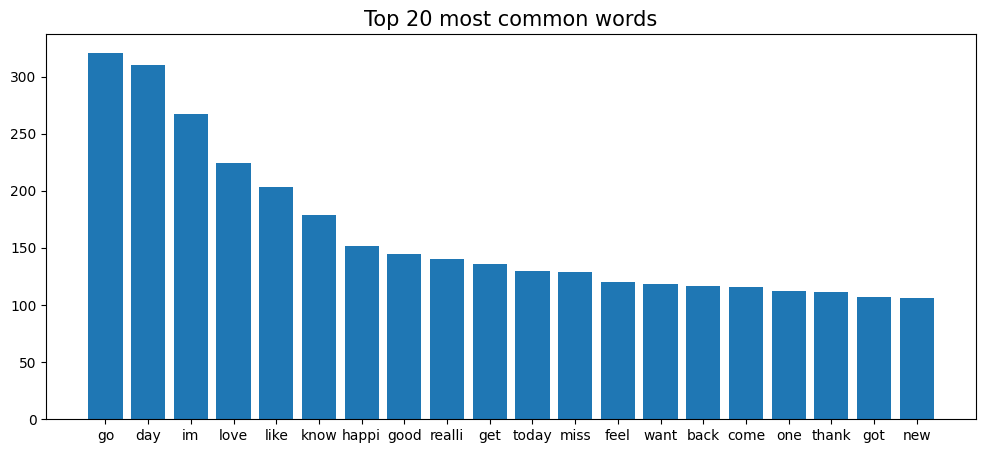

In [59]:
import matplotlib.pyplot as plt
keys = []
values = []
for key, value in sorted_words[:20]:
    keys.append(key)
    values.append(value)
    
plt.figure(figsize=(12, 5))
plt.bar(keys, values)
plt.title('Top 20 most common words', size=15)
plt.show()

In [60]:
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

reviews_int = []
for text in combined_df['text']:
    r = [vocab_to_int[word] for word in text.split()]
    reviews_int.append(r)

print(reviews_int[:1])
combined_df['Review int'] = reviews_int

[[41, 2, 38, 5, 394]]


In [61]:
review_len = [len(x) for x in reviews_int]
combined_df['Review len'] = review_len


count    2495.000000
mean        8.860922
std         8.069931
min         0.000000
25%         4.000000
50%         6.000000
75%        11.000000
max        54.000000
Name: Review len, dtype: float64


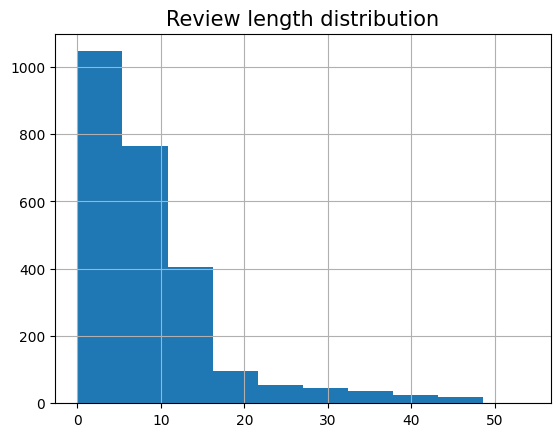

In [62]:
print(combined_df['Review len'].describe())

combined_df['Review len'].hist()
plt.title('Review length distribution', size=15)
plt.show()

In [63]:
def Padding(review_int, seq_len):
    '''
    Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_len), dtype = int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)
            
    return features

In [64]:
import numpy as np
features = Padding(reviews_int, 50)
print(features[0, :])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  41   2  38   5 394]


In [65]:
from sklearn.model_selection import train_test_split
X_train, X_remain, y_train, y_remain = train_test_split(features, combined_df['sentiment'].to_numpy(), test_size=0.2, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_remain, y_remain, test_size=0.5, random_state=1)

In [66]:
print(X_train.shape)  # Should be (num_train_samples, seq_len)
print(X_test.shape)   # Should be (num_test_samples, seq_len)
print(X_valid.shape)  # Should be (num_valid_samples, seq_len)


(1996, 50)
(250, 50)
(249, 50)


In [67]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
# create tensor dataset
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

# dataloaders
batch_size = 8

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [68]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([8, 50])
Sample input: 
 tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,  330,  135,  345,  500, 1837,  707,  418, 1522,  564,
          347,  315],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,   13,   43,  301,
           12,  300],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
         

In [69]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.2):
        super(SentimentLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,dropout=drop_prob, batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        
        # Softmax activation for multi-class classification
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        
        # Embedding and LSTM output
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # Stack up LSTM outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         # Only take the output of the last LSTM cell
#         lstm_out = lstm_out[:, -1, :]
        # Dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # Softmax function
        soft_out = self.softmax(out)
        
        # Reshape into batch_size and output_size
        soft_out = soft_out.view(batch_size, -1, self.output_size)
        soft_out = soft_out[:, -1]
        
        return soft_out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        return hidden

# Hyperparameters
vocab_size = len(vocab_to_int) + 1
output_size = 3  # Three classes: 0, 1, 2
embedding_dim = 30
hidden_dim = 32
n_layers = 2
model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(model)


SentimentLSTM(
  (embedding): Embedding(2429, 30)
  (lstm): LSTM(30, 32, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


In [70]:
# Hyperparameters
epochs = 15
lr = 0.001
clip = 5  # gradient clipping
wandb.init(
      project="lstm_sentiment_analysis", 
      name=f"test4_jvb1", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": lr,
      "architecture": "LSTM",
      "dataset": "vsa",
      "epochs": epochs,
      })
wandb.watch(model)

Train Accuracy,▁▄▆▇▇███████████████
Train Loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val Accuracy,▁▅▇▇▇█▇█▇█▇█▇████▇█▇
Val Loss,█▄▃▂▂▁▂▁▁▁▂▁▂▁▁▁▁▂▁▂
Train Accuracy,0.978
Train Loss,0.57385
Val Accuracy,0.84375
Val Loss,0.70949


[]

In [71]:
import torch.optim as optim
import numpy as np
import random

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# # Hyperparameters
# epochs = 10
# lr = 0.001
# clip = 5  # gradient clipping

def accuracy(predictions, labels):
    _, preds = torch.max(predictions, 1)
    correct = preds.eq(labels.view_as(preds)).sum()
    acc = correct.float() / preds.shape[0]
    return acc

# Loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

valid_loss_min = np.Inf

# Training loop
for epoch in range(epochs):
    train_losses = []
    train_accs = []
    model.train()

    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Khởi tạo trạng thái ẩn
        h = model.init_hidden(inputs.size(0))
        h = tuple([each.data for each in h])
        model.zero_grad()

        output, h = model(inputs, h)
        loss = criterion(output, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_accs.append(accuracy(output, labels).item())

    val_losses = []
    val_accs = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)

            # Khởi tạo trạng thái ẩn
            val_h = model.init_hidden(inputs.size(0))
            val_h = tuple([each.data for each in val_h])
            output, val_h = model(inputs, val_h)
            val_loss = criterion(output, labels)
            val_losses.append(val_loss.item())
            val_accs.append(accuracy(output, labels).item())
    
    wandb.log({"Train Loss": np.mean(train_losses)})
    wandb.log({"Train Accuracy": np.mean(train_accs)})
    wandb.log({"Val Loss": np.mean(val_losses)})
    wandb.log({"Val Accuracy": np.mean(val_accs)})
    
    # Print training/validation statistics
    print(f"Epoch: {epoch+1}/{epochs}... "
          f"Train Loss: {np.mean(train_losses):.6f}... "
          f"Val Loss: {np.mean(val_losses):.6f}... "
          f"Train Acc: {np.mean(train_accs) * 100:.2f}%... "  # Nhân accuracy với 100
          f"Val Acc: {np.mean(val_accs) * 100:.2f}%")  # Nhân accuracy với 100

    # Save model if validation loss has decreased
    if np.mean(val_losses) <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {np.mean(val_losses):.6f}). Saving model ...')
        torch.save(model.state_dict(), 'state_dict.pt')
        valid_loss_min = np.mean(val_losses)

    print(25 * '==')


Epoch: 1/15... Train Loss: 1.076535... Val Loss: 1.042914... Train Acc: 41.00%... Val Acc: 49.61%
Validation loss decreased (inf --> 1.042914). Saving model ...
Epoch: 2/15... Train Loss: 0.963936... Val Loss: 0.910947... Train Acc: 57.75%... Val Acc: 62.50%
Validation loss decreased (1.042914 --> 0.910947). Saving model ...
Epoch: 3/15... Train Loss: 0.829016... Val Loss: 0.822188... Train Acc: 73.00%... Val Acc: 73.44%
Validation loss decreased (0.910947 --> 0.822188). Saving model ...
Epoch: 4/15... Train Loss: 0.746470... Val Loss: 0.767825... Train Acc: 81.10%... Val Acc: 77.34%
Validation loss decreased (0.822188 --> 0.767825). Saving model ...
Epoch: 5/15... Train Loss: 0.699284... Val Loss: 0.758054... Train Acc: 85.35%... Val Acc: 78.52%
Validation loss decreased (0.767825 --> 0.758054). Saving model ...
Epoch: 6/15... Train Loss: 0.668720... Val Loss: 0.726293... Train Acc: 88.50%... Val Acc: 82.81%
Validation loss decreased (0.758054 --> 0.726293). Saving model ...
Epoch: 7/

In [72]:
# Get test data loss and accuracy

test_losses = [] # track loss
# num_correct = 0

test_acc = 0.0

def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()
model.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    # init hidden state
    test_h = model.init_hidden(inputs.size(0))
    test_h = tuple([each.data for each in test_h])

    inputs, labels = inputs.to(device), labels.to(device)
    inputs, labels = inputs.to(torch.int64), labels.long()

    output, test_h = model(inputs, test_h)
    
    # calculate loss
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    
    accuracy = acc(output,labels)
    test_acc += accuracy


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = test_acc/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

# epoch_test_acc = test_acc/len(test_loader.dataset)

Test loss: 0.734
Test accuracy: 82.000%


In [73]:
import torch.nn.functional as F
def make_prediction(text):
    # Tiền xử lý text
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)

    # Chuyển đổi text thành dạng số
    text_int = []
    for word in text.split():
        if word in vocab_to_int:
            text_int.append(vocab_to_int[word])
        else:
            text_int.append(vocab_to_int['<UNK>']) # Xử lý từ không có trong vocab

    # Đệm text
    text_padded = Padding([text_int], 50)[0]
    # Convert the NumPy array to a PyTorch tensor
    text_tensor = torch.tensor(text_padded)

    # Move the tensor to the same device as the model
    text_tensor = text_tensor.to(device)
    # Dự đoán nhãn
    model.eval()
    with torch.no_grad():
        output, hidden = model(text_tensor.unsqueeze(0), model.init_hidden(1))
        probabilities = F.softmax(output, dim=1).squeeze()
        pred = output.argmax(dim=1).item()

    return pred, probabilities


In [74]:
def de_mapping(val):
    category_map = {
       0:'neutral',
        1:'positive',
        2:'negative'
     }
    return category_map.get(val,-1)

In [75]:
text = "This is a great movie!"
pred, probabilities = make_prediction(text)
print(f"Predicted label: {pred} - {de_mapping(pred)}")
print(f"Prediction probabilities: {probabilities}")

Predicted label: 1 - positive
Prediction probabilities: tensor([0.2121, 0.5757, 0.2122], device='cuda:0')


In [76]:
text = 'Always somewhere I miss you where I have been'
pred, probabilities = make_prediction(text)
print(f"Predicted label: {pred} - {de_mapping(pred)}")
print(f"Prediction probabilities: {probabilities}")

Predicted label: 0 - neutral
Prediction probabilities: tensor([0.5758, 0.2120, 0.2122], device='cuda:0')


In [77]:
text = 'i want to drink water'
pred, probabilities = make_prediction(text)
print(f"Predicted label: {pred} - {de_mapping(pred)}")
print(f"Prediction probabilities: {probabilities}")

Predicted label: 0 - neutral
Prediction probabilities: tensor([0.4541, 0.2333, 0.3126], device='cuda:0')


In [78]:
text = 'i want to drink water'
pred, probabilities = make_prediction(text)
print(f"Predicted label: {pred} - {de_mapping(pred)}")
print(f"Prediction probabilities: {probabilities}")

Predicted label: 0 - neutral
Prediction probabilities: tensor([0.4541, 0.2333, 0.3126], device='cuda:0')
